# W207 Final Project

## Submission by Sirisha Bhupathi and Abhi Sharma

This project is for the Kaggle competition listed here: https://www.kaggle.com/c/facial-keypoints-detection

## Objective

The objective of this project is to predict keypoint positions on face images.

## Introduction

The image sizes are 96 x 96 pixels and the key points are represented as location co-ordinates for each image. 
Location co-ordinates can have 2 values - one for x and one for y. 
There are a total of 30 location co-ordinates per image, 15 each for the x and y axis.
Out of the 30 co-ordinates in the test dataset for a single image, some co-ordinates are present and others need to be predicted. 
The number and type of co-ordinates that need to be predicted vary per test example.


## Imports and Settings

In [39]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randint
import time
import math
import random

# import keras, tf and image depdencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import tensorflow_hub as hub
from tensorflow.keras import layers
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import cv2

In [40]:
#set seed for reprodibility
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [41]:
# We verify if the GPU is working and available with the following commands
# Adapted from here: https://www.tensorflow.org/guide/gpu

tf_config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.compat.v1.Session(config=tf_config)
tf.compat.v1.keras.backend.set_session(s)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
#tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Physical devices cannot be modified after being initialized


## Data Loading

In [42]:
# Constants
IMG_DIM = 96
PIX_MAX = 255
IMAGE = 'Image'
COLUMNS = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']

CWD = '/project/notebooks'
AUGMENTATIONS = ["90R", "90L", "180H", "180V", "NoiseGaussian", "NoiseSaltPepper", "NoisePoisson", "NoiseSpeckle", "BrightDarkAug", "BlurAvg", "BlurGaussian", "MoveLeft", "MoveRight"]

In [43]:
folder_prefix = '..'
if os.getcwd() == CWD:
    folder_prefix = '/project/kaggle'

In [44]:
train = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/training.zip')
test = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/test.zip')
idlookup = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/IdLookupTable.csv')

In [45]:
print('Train shape:',train.shape)
print('Test shape:',test.shape)

Train shape: (7049, 31)
Test shape: (1783, 2)


In [46]:
train.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [47]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Data Validation

In [48]:
# Check for missing values
def check_missing_vals(data):
    return data.isnull().any().value_counts()
    
def fill_missing_with_col_mean(data):
    for col in COLUMNS:
        mean = np.mean(data[col])
        data[col] = data[col].fillna(mean)
    return data

In [49]:
check_missing_vals(train)

True     28
False     3
dtype: int64

In [50]:
check_missing_vals(test)

False    2
dtype: int64

In [51]:
train = fill_missing_with_col_mean(train)
check_missing_vals(train)

False    31
dtype: int64

## Feature Engineering and Augmentation

In [52]:
# Split image column and label columns

train_images = train[[IMAGE]]
train_labels = train.drop(IMAGE, axis=1)

train_images.head()

,Image
0,238 236 237 238 240 240 239 241 241 243 240 23...
1,219 215 204 196 204 211 212 200 180 168 178 19...
2,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,147 148 160 196 215 214 216 217 219 220 206 18...


In [53]:
# Split train image pixels from string to 1 pixel per column and convert each pixel from string to float

train_images = train_images[IMAGE].str.split(' ', expand=True)
train_images = train_images.astype(float)

train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238.0,236.0,237.0,238.0,240.0,240.0,239.0,241.0,241.0,243.0,...,33.0,29.0,30.0,34.0,39.0,49.0,62.0,70.0,75.0,90.0
1,219.0,215.0,204.0,196.0,204.0,211.0,212.0,200.0,180.0,168.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,144.0,142.0,159.0,180.0,188.0,188.0,184.0,180.0,167.0,132.0,...,64.0,60.0,56.0,61.0,70.0,69.0,71.0,78.0,78.0,77.0
3,193.0,192.0,193.0,194.0,194.0,194.0,193.0,192.0,168.0,111.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,147.0,148.0,160.0,196.0,215.0,214.0,216.0,217.0,219.0,220.0,...,33.0,34.0,37.0,37.0,43.0,46.0,83.0,140.0,170.0,176.0


In [54]:
check_missing_vals(train_images)

False    9216
dtype: int64

In [55]:
check_missing_vals(train_labels)

False    30
dtype: int64

In [56]:
# Split test image pixels from string to 1 pixel per column and convert each pixel from string to float

test_images = test.copy()
test_images = test_images.set_index('ImageId')
test_images = test_images[IMAGE].str.split(' ', expand=True)
test_images = test_images.astype(float)

test_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
ImageId,,,,,,,,,,,,,,,,,,,,,
1,182.0,183.0,182.0,182.0,180.0,180.0,176.0,169.0,156.0,137.0,...,6.0,14.0,28.0,28.0,24.0,18.0,12.0,8.0,5.0,5.0
2,76.0,87.0,81.0,72.0,65.0,59.0,64.0,76.0,69.0,42.0,...,156.0,152.0,162.0,169.0,168.0,159.0,191.0,228.0,211.0,168.0
3,177.0,176.0,174.0,170.0,169.0,169.0,168.0,166.0,166.0,166.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,176.0,174.0,174.0,175.0,174.0,174.0,176.0,176.0,175.0,171.0,...,144.0,143.0,141.0,142.0,143.0,142.0,142.0,142.0,142.0,140.0
5,50.0,47.0,44.0,101.0,144.0,149.0,120.0,58.0,48.0,42.0,...,254.0,254.0,254.0,253.0,255.0,236.0,174.0,175.0,175.0,165.0


In [57]:
check_missing_vals(test_images)

False    9216
dtype: int64

In [58]:
# Plot images and keypoints function
# if img_num is a valid value, we display that image only

def plot_images(train_images, train_labels, start_index=0, end_offset=1000, img_num=-1):
    rows = 4
    cols = 4
    multiplier = 10
    dot_size = 100
    
    if img_num != -1:
        dot_size = 50
        multiplier = 5
        rows = 1
        cols = 1
        
    fig = plt.figure(figsize=(rows * multiplier, cols * multiplier), constrained_layout = False)
    for i in range(1, cols * rows + 1):
        ax = fig.add_subplot(rows, cols, i)
        if img_num != -1:
            image_no = img_num
        else:
            image_no = randint(start_index, start_index+end_offset)
        img = np.array(train_images.iloc[image_no]).reshape(IMG_DIM, IMG_DIM)
        ax.imshow(img, cmap='gray')
        for j in range(0, 30, 2):
            ax.scatter(train_labels.iloc[image_no][j], train_labels.iloc[image_no][j+1], s=dot_size)
    plt.show()

    
def plot_image_with_label_optional(img, labels=pd.DataFrame()):
    fig = plt.figure(figsize=(5, 5), constrained_layout = False)
    # reshapes array in case it is given as flat representation, ie, 9216 pixels = 96 x 96 image
    img = np.array(img).reshape(IMG_DIM, IMG_DIM)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    if labels.empty == False:
        for j in range(0, 30, 2):
            ax.scatter(labels[j], labels[j+1], s=50)
    return fig

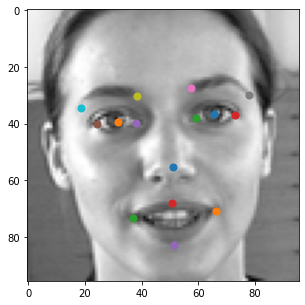

In [59]:
# Display single image giving index as input
plot_images(train_images, train_labels, img_num=20)

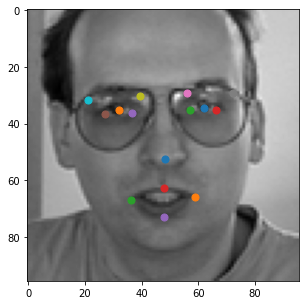

In [60]:
# Display another image directly giving image and label as input
plot_image_with_label_optional(train_images.iloc[155], train_labels.iloc[155]).show()

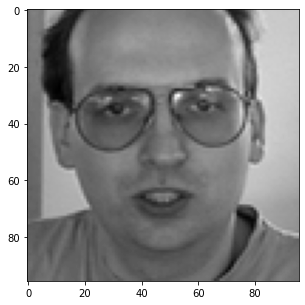

In [61]:
# Display same image without any labels
plot_image_with_label_optional(train_images.iloc[155]).show()

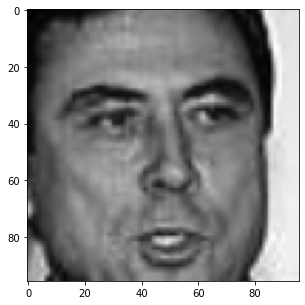

In [62]:
# Can plot some test images as well
# Plotting many of these we see that images are sometimes blurry + slightly translated (left or right)
plot_image_with_label_optional(test_images.iloc[990]).show()

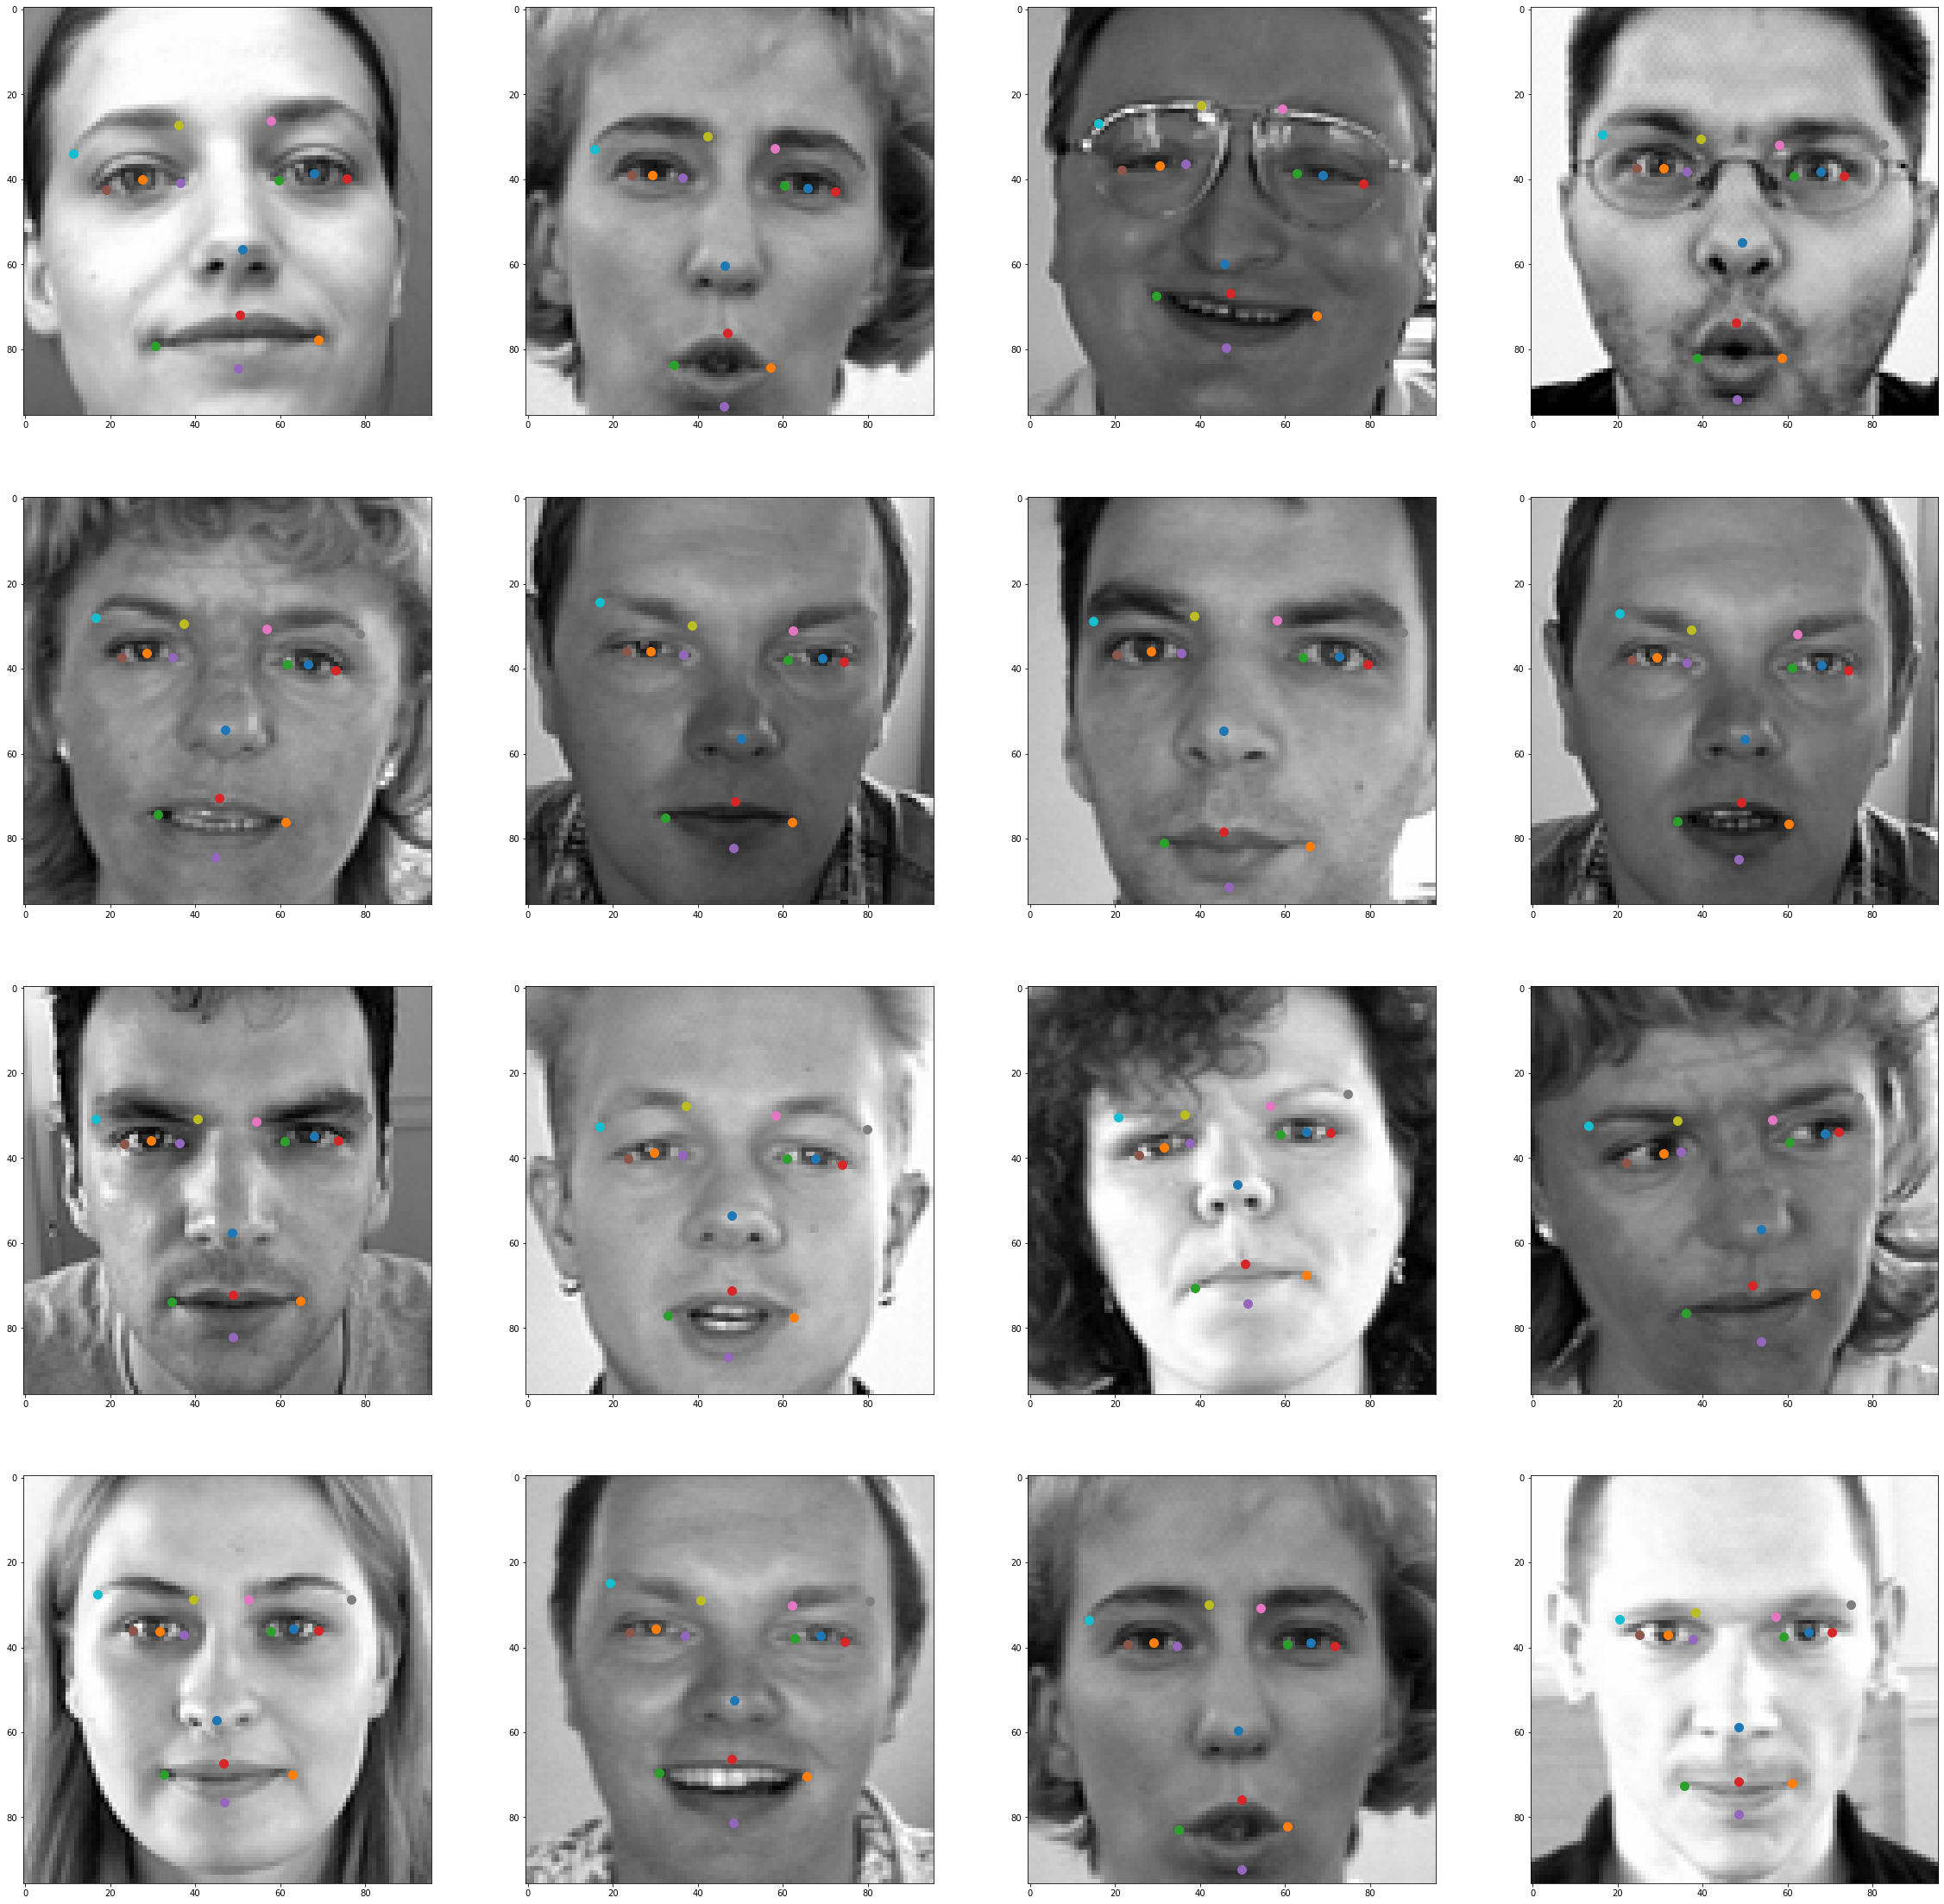

In [63]:
# Display many train images
plot_images(train_images, train_labels)

In [64]:
# Augmentation function to generate more images

def augment_images(train_img_set, train_label_set, aug_list):
    """Takes training images and augmentation type and returns augmented images"""
    tick = time.perf_counter()
    for aug in aug_list:
        if aug not in AUGMENTATIONS:
            raise NameError("Augmentation -- {0} -- not valid".format(aug))
    
    if len(train_img_set) != len(train_label_set):
        raise ValueError("Train image set size must match label set size")
    
    output_imgs_flat = []
    output_imgs_2d = []
    output_label_set = []
    angle = 0
    for aug in aug_list:
        for idx, img in train_img_set.iterrows():

            labels = list(train_label_set.iloc[idx].copy())
            input_image = img.copy()
            if img.shape != (IMG_DIM, IMG_DIM):
                #print("Converting image to 2d")
                input_image = img_reshape_2d(input_image)

            output_image = Image.fromarray(input_image)
            if aug == "90R":
                # rotate 90 degrees to the right
                output_image = output_image.rotate(270)
                angle = 90
            elif aug == "90L":
                # rotate 90 degrees to the left
                output_image = output_image.rotate(90)
                angle = -90
            elif aug == "180H":
                # horizontal flip
                output_image = ImageOps.mirror(output_image)
                angle = 0
            elif aug == "180V":
                # rotate 180 degrees vertically
                output_image = output_image.rotate(180)
                angle = 180
            elif aug == "NoiseGaussian" or aug == "NoiseSaltPepper" or aug == "NoisePoisson" or aug == "NoiseSpeckle":
                output_image = add_noise_to_img(input_image, aug)
                angle = 0
            elif aug == "BrightDarkAug":
                output_image = cv2.convertScaleAbs(input_image, alpha=1, beta=random.randint(10, 200))
                angle = 0
            elif aug == "BlurAvg":
                output_image = cv2.blur(input_image, (4,4))
                angle = 0
            elif aug == "BlurGaussian":
                output_image = cv2.GaussianBlur(input_image, (9,9), 0)
                angle = 0
            elif aug == "MoveLeft":
                rows, cols = input_image.shape
                translation_amount = 7
                M = np.float32([[1, 0, translation_amount], [0, 1, 0]])
                output_image = cv2.warpAffine(input_image, M, (cols, rows))
                # setting angle 0 will return image labels as is, so image wont rotate
                angle = 0
                # translate image horizontally
                labels = translate_points_horizontal(labels, translation_amount)
            elif aug == "MoveRight":
                rows, cols = input_image.shape
                translation_amount = -7
                M = np.float32([[1, 0, translation_amount], [0, 1, 0]])
                output_image = cv2.warpAffine(input_image, M, (cols, rows))
                # setting angle 0 will return image labels as is, so image wont rotate
                angle = 0
                # translate image horizontally
                labels = translate_points_horizontal(labels, translation_amount)
            
            output_image = np.array(output_image)
            output_imgs_flat.append(output_image.reshape(IMG_DIM * IMG_DIM))
            output_imgs_2d.append(output_image)
            
            labels = rotate_points((IMG_DIM / 2, IMG_DIM / 2), labels, angle)
            output_label_set.append(labels)
    
    output_imgs_flat = np.array(output_imgs_flat)
    output_imgs_2d = np.array(output_imgs_2d).reshape(-1, IMG_DIM, IMG_DIM, 1)
    output_label_set = np.array(output_label_set)
    tock = time.perf_counter()
#     print("Time elapsed (sec) for augmentation is {0}".format(tock-tick))
    
    return output_imgs_flat, output_imgs_2d, output_label_set



In [65]:
# Utility function for adding noise to the image. Note that the keypoints are not altered in such a case

def add_noise_to_img(image, noise_type = "NoiseGaussian"):
    
    row, col = image.shape
    # channel is always 1 because we are dealing with grey scale images
    ch = 1
    if noise_type == "NoiseGaussian":
        mean = 100
        var = 100
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss

    elif noise_type == "NoiseSaltPepper":
        s_vs_p = 0.5
        amount = 0.04
        noisy = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords] = 0
  
    elif noise_type == "NoisePoisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
    
    elif noise_type == "NoiseSpeckle":
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col)        
        noisy = image + image * gauss
    
    return noisy

In [66]:
# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate_points(origin, points, angle):
    if angle == 0:
        return points
    
    angle = math.radians(angle)
    result = []
    ox, oy = origin
    for p in range(0, len(points), 2):
        px, py = points[p], points[p+1]

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        result.append(qx)
        result.append(qy)
        
    return result

In [67]:
def translate_points_horizontal(points, translation_amount):
    result = []
    
    for p in range(0, len(points), 2):
        px, py = points[p], points[p+1]
        result.append(px + translation_amount)
        # y coordinates remain the same
        result.append(py)
        
    return result

In [68]:
aug_list = ["NoiseGaussian", "NoiseSpeckle", "NoisePoisson", "NoiseSaltPepper", "BrightDarkAug", "BlurAvg", "BlurGaussian"]
img_display = 20

In [69]:
# Utility function to reshape image(s) to 2d
# Note that a dataframe is converted into a numpy array as a result of this transform
# Thus it is the user's responsibility to convert the array back to a dataframe if need be

def img_reshape_2d(data, width=IMG_DIM, height=IMG_DIM):
    data_2d = data.values.reshape(width, height)
    # returns data of shape (width, height)
    return data_2d

def multiple_img_reshape_2d(data, width=IMG_DIM, height=IMG_DIM):
    data_2d = data.values.reshape(data.shape[0], width, height, 1)
    # returns data of shape (rows, width, height, color channels)
    return data_2d

In [70]:
temp_train_img_flat, temp_train_img_2d, temp_train_labels = augment_images(train_images[0:5], train_labels[0:5], aug_list)


In [71]:
temp_train_labels_df = pd.DataFrame(temp_train_labels, columns = COLUMNS)

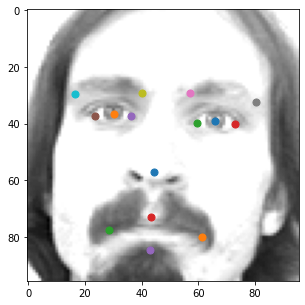

In [72]:
# Plot left rotation for single image
plot_image_with_label_optional(temp_train_img_flat[img_display], temp_train_labels_df.iloc[img_display]).show()

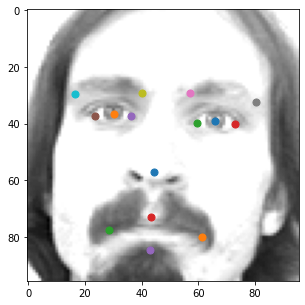

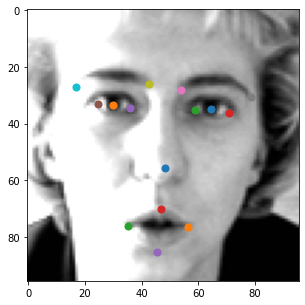

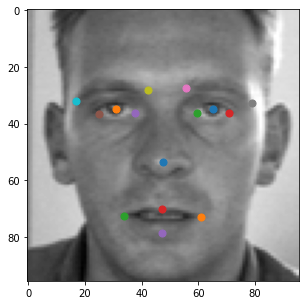

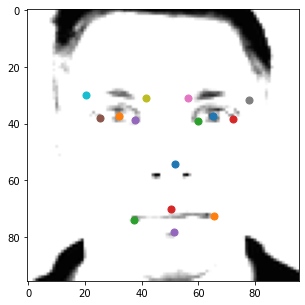

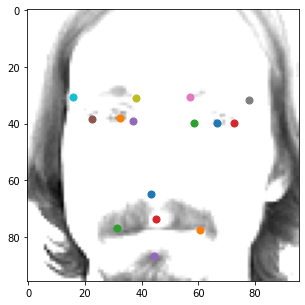

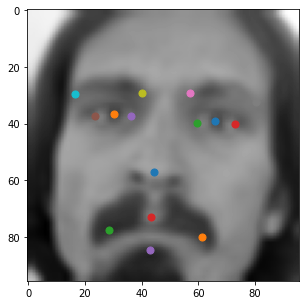

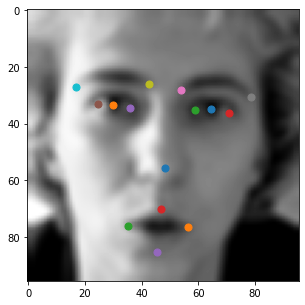

In [73]:
# Display all augmentations for a single image
num_train_examples = 1
for i in range(len(aug_list)):
    plot_image_with_label_optional(temp_train_img_2d[img_display + (i*num_train_examples)], temp_train_labels_df.iloc[img_display + (i*num_train_examples)]).show()

## Data Preparation

Reshape the training data into 2d 

In [74]:
print(train_images.shape)
print(test_images.shape)

train_images_2d = multiple_img_reshape_2d(train_images)
test_images_2d = multiple_img_reshape_2d(test_images)

print(train_images_2d.shape)
print(test_images_2d.shape)

(7049, 9216)
(1783, 9216)
(7049, 96, 96, 1)
(1783, 96, 96, 1)


**Deep learning models are known to work well with normalized data. Thus we normalize the image pixel values with the highest pixel value intensity, ie, 255. We also normalize the labels with the width of the image size.**

## Modeling and Training

In [75]:
# # train and test data for full training

# train_images_scaled = train_images / PIX_MAX
# test_images_scaled = test_images / PIX_MAX
# train_images_2d_scaled = train_images_2d / PIX_MAX
# test_images_2d_scaled = test_images_2d / PIX_MAX

# train_labels_scaled = train_labels / IMG_DIM

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import optimizers
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

We are going to split the data in train and test, so we can run iterations. Not all iterations are shown below, a few experiments were done in place. But the general progression with key changes is shown. First we will optimize for architecture followed by iterations and kernel size etc.

In [96]:
#Split data into train and test, validation is within the model loop
from sklearn.metrics import mean_squared_error

X_train = train_images.iloc[:5640,]
y_train = train_labels.iloc[:5640,]
X_test = train_images.iloc[5640:,]
y_test = train_labels.iloc[5640:,]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#optimized model with train and test split data
X_train_2d = multiple_img_reshape_2d(X_train)
X_test_2d = multiple_img_reshape_2d(X_test)

X_train_2d_scaled = X_train_2d/255
X_test_2d_scaled = X_test_2d/255
y_train_scaled = y_train/96
y_test_scaled = y_test/96

(5640, 9216)
(5640, 30)
(1409, 9216)
(1409, 30)


In [111]:
def CNN_model1(train, labels, act):
    model = Sequential()
    
    if act == 'relu':
        model.add(Conv2D(32, kernel_size=(5,5),activation='relu', padding='same', use_bias=True ,input_shape=(96,96,1)))
    else:
        model.add(Conv2D(32, kernel_size=(5,5),padding='same', use_bias=True ,input_shape=(96,96,1)))
        model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse','mae'])
    history = model.fit(train, labels, epochs = 100, batch_size = 100,validation_split = 0.2, verbose =0)
    
    return model, history

for act in ['relu','leakyrelu']:
    model, history = CNN_model1(X_train_2d_scaled,y_train_scaled, act)
    print(act, 'optimized test error:', mean_squared_error(y_test_scaled,model.predict(X_test_2d_scaled)))

relu optimized test error: 0.0003024693301974574
leakyrelu optimized test error: 0.0002911180518890809


Have also tried strides (1,1), (2,2) and (3,3) and found (1,1) to be the best.
Also tried several leakyrelu alpha and found 0.1 to be the best.

Check kernel window sizes

In [113]:
# Kernel/window optimization
def CNN_model2(train, labels, k):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(k,k),padding='same', use_bias=True ,input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse','mae'])
    history = model.fit(train, labels, epochs = 100, batch_size = 100,validation_split = 0.2, verbose =0)
    
    return model, history

for k in [2,3,4,5]:
    model, history = CNN_model2(X_train_2d_scaled,y_train_scaled, k)
    print(k, 'optimized test error:', mean_squared_error(y_test_scaled,model.predict(X_test_2d_scaled)))

2 optimized test error: 0.000324458168629813
3 optimized test error: 0.00029955877024970804
4 optimized test error: 0.00028609324136463635
5 optimized test error: 0.0002959389050181417


In [118]:
def CNN_model3(train, labels,l):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(4,4),padding='same', use_bias=True ,input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    if l >1:
        model.add(Conv2D(64, kernel_size=(4,4),padding='same', use_bias=True))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(2,2))
        
        if l>2:
            model.add(Conv2D(128, kernel_size=(4,4),padding='same', use_bias=True))
            model.add(LeakyReLU(alpha=0.1))
            model.add(MaxPooling2D(2,2))
            
            if l >3:
                model.add(Conv2D(256, kernel_size=(4,4),padding='same', use_bias=True))
                model.add(LeakyReLU(alpha=0.1))
                model.add(MaxPooling2D(2,2))

                if l>4:
                    model.add(Conv2D(512, kernel_size=(4,4),padding='same', use_bias=True))
                    model.add(LeakyReLU(alpha=0.1))
                    model.add(MaxPooling2D(2,2))
                    
                    if l>5:
                        model.add(Conv2D(1024, kernel_size=(4,4),padding='same', use_bias=True))
                        model.add(LeakyReLU(alpha=0.1))
                        model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse','mae'])
    history = model.fit(train, labels, epochs = 100, batch_size = 100,validation_split = 0.2, verbose =0)
    
    return model, history

for l in [1,2,3,4,5,6]:
    model, history = CNN_model3(X_train_2d_scaled,y_train_scaled, l)
    print(l, 'optimized test error:', mean_squared_error(y_test_scaled,model.predict(X_test_2d_scaled)))

1 optimized test error: 0.0002938639041107986
2 optimized test error: 0.0002651761800115691
3 optimized test error: 0.00024927715906572446
4 optimized test error: 0.00023465633497982052
5 optimized test error: 0.0002445918212774337
6 optimized test error: 0.00024896221321564293


Chosen optimized model below

In [ ]:
def CNN_model4(train, labels,epochs,batch_size):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(4,4),padding='same', use_bias=True ,input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, kernel_size=(4,4),padding='same', use_bias=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, kernel_size=(4,4),padding='same', use_bias=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(256, kernel_size=(4,4),padding='same', use_bias=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(512, kernel_size=(4,4),padding='same', use_bias=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse','mae'])
    history = model.fit(train, labels, epochs = epochs, batch_size = batch_size,validation_split = 0.2, verbose =0)
    
    return model, history

for e in [50,100]:
    for b in [50,100,1000]: 
        model, history = CNN_model4(X_train_2d_scaled,y_train_scaled, e, b)
        print('epoch',e, 'batch',b, 'optimized test error:', mean_squared_error(y_test_scaled,model.predict(X_test_2d_scaled)))

epoch 50 batch 50 optimized test error: 0.000254183621244741
epoch 50 batch 100 optimized test error: 0.00023901193905198452
epoch 50 batch 1000 optimized test error: 0.0005048773539676364
epoch 100 batch 50 optimized test error: 0.00023003229492211702
epoch 100 batch 100 optimized test error: 0.00023694181773123432
epoch 100 batch 1000 optimized test error: 0.00040393212504834984


The above model parameters were achieved after several rounds of parameter tuning using the set up below as well are comparing the kaggle score.
Showing a few parameter iterations below. Changes in architecture such as adding layers and dropout etc were done in place and have no history.

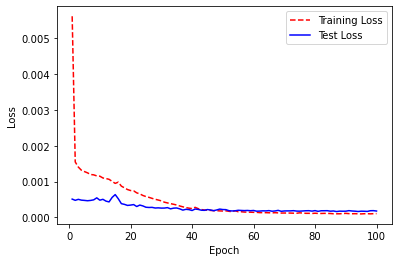

In [79]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### With Augmentation

To test if the augmentation works, we ran the optimized model on training data after augmentations.

In [ ]:
# Normalize train and test data

AUGMENTATIONS = ["90R", "90L", "180H", "180V", "NoiseGaussian", "NoiseSaltPepper", "NoisePoisson", "NoiseSpeckle", "BrightDarkAug", "BlurAvg", "BlurGaussian", "MoveLeft", "MoveRight"]

for aug in AUGMENTATIONS:
    #Get augmented images
    temp_train_img_flat, temp_train_img_2d, temp_train_labels = augment_images(X_train, y_train, [aug])
    temp_train_img_flat = pd.DataFrame(temp_train_img_flat)
    temp_train_labels = pd.DataFrame(temp_train_labels)
    temp_train_labels.columns = y_train.columns

    #merge augmented images with training data
    X_train_augmented = pd.concat([X_train,temp_train_img_flat],ignore_index=True)
    y_train_augmented = pd.concat([y_train,temp_train_labels])

    # print(X_train_augmented.shape)
    # print(y_train_augmented.shape)

    #reshape training data
    X_train_augmented_2d = multiple_img_reshape_2d(X_train_augmented)

    #scale training sets
    X_train_augmented_2d_scaled = X_train_augmented_2d/255
    y_train_augmented_scaled = y_train_augmented/96

#     model, history = CNN_model(X_train_augmented_2d_scaled,y_train_augmented_scaled)
#     print(aug, 'optimized test error:', mean_squared_error(y_test_scaled,model.predict(X_test_2d_scaled)))

The above cell block take considerably long to run. We did not notice any descernable decrease in error so augmentation did not help in the end.

## Optimal model

While we did use separate train, validation, test datasets, our hyperparameter tuning still happened on the test set, which means we could have still ended up overfitting the model. So we chose a few best case models out of the above and submitted them to Kaggle score. And found the below to be the best optimal model -

model: layers = 5, kernel size = 3
score: 2.31 RMSE

Note that this was not the lowest RMSE models on the X_test as we chose but were the lowest on Kaggle. In real world, we would not have such helpful leaderboard and we would have ended up choosing 4 layered, 4x4 kernel window model. The difference is about 2.34 vs. 2.31, about 9% higher error, which is a big deal. 

However, even in real world, we would continuously improve the model as we consume more and more data, so we would assume eventually model will converge to the Kaggle leaderboard optimal or maybe even surpass it.

In [ ]:
#Final chosen model
train_images_scaled = train_images / PIX_MAX
test_images_scaled = test_images / PIX_MAX
train_images_2d_scaled = train_images_2d / PIX_MAX
test_images_2d_scaled = test_images_2d / PIX_MAX

train_labels_scaled = train_labels / IMG_DIM


# Optimal model:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),padding='same', use_bias=True ,input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse','mae'])
history = model.fit(train_images_2d,train_labels,epochs = 100,batch_size = 100,validation_split = 0.2) 

## Final thoughts

We have tested several version of the model changing various parameters. A brief summary of our learnings below:
- **Activation:** In this particular instant LeakyReLU which is more forgiving of negative inputs than Relu is better suited and gives lower error on the test. There is no descernable difference in time taken by both
- **Kernel size:** While in general smaller windows increase the accuracy, there is an optimal kernel size. Smaller window size also take longer to run.
- **Filters and layers:** The number of filters was an interesting observation. As expected the run time increases with higher number of filters (32,64, etc.). But the gain wasn't always positive. It is best to utilize 32 filters first and then incrementally add more in later layers. The more number of layers, higher the run time. But the gain palteaus at some point.
- **epochs:** The more number of epochs, obviously higher the run time. But there is a peak in terms of test accuracy gain. Beyond which model will ovefit to training data and test score will get worse
- **batcn size:** Batch size was an interesting learning. This actually had impact on test score. the few images processed in  each batch the better the score. A quick research showed that this might be to do with gradiet averaging and that there is again an optimal value. Too low a batch size will destabilize the model, while too large may result in model not learning enough

One last thought, looking through the train images we can see that these are relatively clean images that are artificially modified for a learning competition. Which is liekly why the gain of CNN over a simple average model isn't as stark as we would normally see.

**Further improvements** The model can definitely be improved further by changing the model architecture. We stopped model tuning once we achieved our goal of coming in Top 50.

Overall this has been an incredible learning and a fun challenge!


In [ ]:
# Predict for test
pred = model.predict(test_images_2d_scaled)
print(np.min(pred))
print(np.max(pred))

## Submission to Kaggle for Scoring

In [ ]:
# Look up table, drop Location field
print(idlookup.head(2))
idlookup = idlookup.drop('Location',axis=1)
print(idlookup.head(2))

#Attach feature names to predictions
feature_names = train_labels.columns
predictions = pd.DataFrame(pred, columns = feature_names)
predictions = predictions * IMG_DIM

predictions.head()
predictions.stack().reset_index()
predictions = predictions.stack().reset_index()
predictions.columns = ['index','FeatureName','Location']

imageids = test['ImageId']
imageids = imageids.reset_index()

predictions = predictions.merge(imageids, left_on='index', right_on='index')
predictions = predictions.drop('index',axis=1)

predictions.head()

In [ ]:
submission = idlookup.merge(predictions, left_on=['FeatureName','ImageId'], right_on=['FeatureName','ImageId'])
submission = submission[['RowId','Location']]
submission = submission.set_index('RowId')
submission.head()

In [ ]:
# Save submission result
    
if os.getcwd() == CWD:
    os.chdir('/project')
    # make submissions directory if it doesnt exist
    try:
        os.makedirs('submissions')
    except OSError as e:
        pass
    
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S").replace('/','').replace(':','').replace(' ','')
    submission.to_csv('submissions/submission-{0}.csv'.format(dt_string))
    os.chdir(CWD)
    
else:
    submission.to_csv('submission.csv')